In [1]:
import os
if "models" not in os.listdir("."):
    os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2
import penzai
from penzai import pz
pz.ts.register_as_default()
pz.ts.register_autovisualize_magic()
pz.enable_interactive_context()

In [3]:
import jax_smi
jax_smi.initialise_tracking()

In [4]:
filename = "models/phi-3-16.gguf"
from micrlhf.llama import LlamaTransformer
llama = LlamaTransformer.from_pretrained(filename, device_map="auto")

In [5]:
from micrlhf.utils.vector_storage import download_vector
layer = 20

In [6]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")
tokenizer.padding_side = "right"

In [7]:
from micrlhf.utils.mmlu_eval import MMLUEval
mmlu_eval = MMLUEval()

In [8]:
resids = mmlu_eval.get_resids(llama, tokenizer, layer)

  0%|          | 0/4422 [00:00<?, ?it/s]

  0%|          | 0/1474 [00:00<?, ?it/s]

phi3-sycophancy-l20-recon-r5: 0.7150106520879835


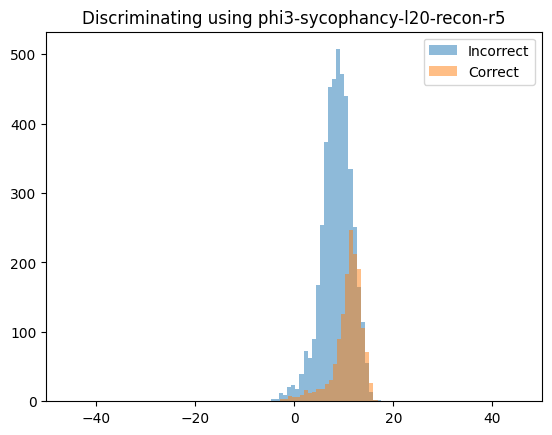

phi3-sycophancy-l20: 0.7807116553896949


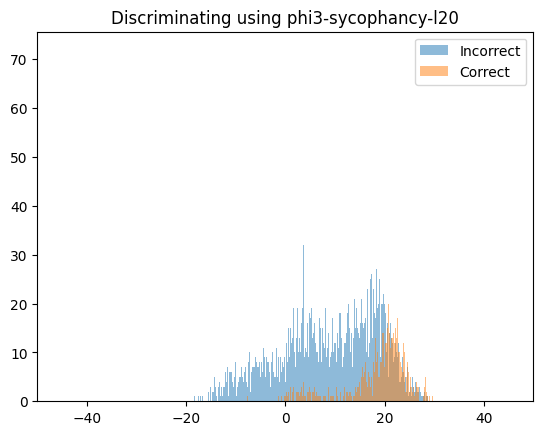

In [11]:
from micrlhf.utils.load_sae import get_sae
from sklearn.metrics import roc_auc_score
import numpy as np
from matplotlib import pyplot as plt

for feat in (9999, 42, 45142, 15036, (20, 5), None)[-2:]:
    if feat is None:
        vector_name = "phi3-sycophancy-l20"
        vector = download_vector(vector_name, overwrite=True)
    elif isinstance(feat, tuple):
        vector_name = f"phi3-sycophancy-l{feat[0]}-recon-r{feat[1]}"
        vector = download_vector(vector_name, overwrite=True)
    else:
        vector_name = f"l20r5 feature {feat}"
        vector = get_sae(20, 5)["W_dec"][feat]
    x = [[], []]
    for vec, correct in resids:
        x[correct].append(float(vec @ vector))
    incorrect = np.asarray(x[0])
    correct = np.asarray(x[1])
    thresholds = np.linspace(-100, 100, 1000)
    labels = [np.ones_like(correct), np.zeros_like(incorrect)]
    roc_auc = max(roc_auc_score(np.concatenate(labels), np.concatenate([correct * s, incorrect * s])) for s in (1, -1))
    print(f"{vector_name}:", roc_auc)
    plt.title(f"Discriminating using {vector_name}")
    plt.xlim(-50, 50)
    plt.hist(x[0], bins=500, alpha=0.5, label="Incorrect")
    plt.hist(x[1], bins=500, alpha=0.5, label="Correct")
    plt.legend()
    plt.show()